In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../../..')

In [3]:
from replay.preprocessing.filters import MinCountFilter
from replay.splitters import TimeSplitter, LastNSplitter, ColdUserRandomSplitter
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

/opt/miniconda3/envs/tst/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [5]:
interactions = pd.read_parquet("/RePlay-Accelerated/replay_benchmarks/data/30music/interactions.parquet")

In [6]:
interactions

,timestamp,item_id,user_id,playtime
0,1405079768,3351207,41504,176
1,1405079944,3351181,41504,181
2,1405080125,3351149,41504,149
3,1405080273,3351170,41504,223
4,1405080497,3351246,41504,290
...,...,...,...,...
31351940,1421379956,3719191,39905,467
31351941,1421530847,808210,39905,718
31351942,1421531288,2382015,39905,490
31351943,1421531780,3628315,39905,290


In [7]:
interactions['playtime'].describe()

count    3.135194e+07
mean     4.154113e+02
std      1.268122e+05
min     -1.000000e+00
25%      1.800000e+02
50%      2.260000e+02
75%      2.780000e+02
max      2.010915e+08
Name: playtime, dtype: float64

In [8]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 45175
Number of unique items: 4519104


In [14]:
pd.to_datetime(interactions['timestamp'], unit='s').describe()

/tmp/ipykernel_1801722/4186389301.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(interactions['timestamp'], unit='s').describe()


count                31351945
unique               18024673
top       2014-04-13 16:00:36
freq                     1120
first     2014-01-20 09:24:20
last      2015-01-20 09:24:18
Name: timestamp, dtype: object

In [15]:
pd.to_datetime(interactions['timestamp'], unit='s')

0          2014-07-11 11:56:08
1          2014-07-11 11:59:04
2          2014-07-11 12:02:05
3          2014-07-11 12:04:33
4          2014-07-11 12:08:17
                   ...        
31351940   2015-01-16 03:45:56
31351941   2015-01-17 21:40:47
31351942   2015-01-17 21:48:08
31351943   2015-01-17 21:56:20
31351944   2015-01-17 22:04:01
Name: timestamp, Length: 31351945, dtype: datetime64[ns]

In [16]:
interactions.head()

,timestamp,item_id,user_id,playtime
0,1405079768,3351207,41504,176
1,1405079944,3351181,41504,181
2,1405080125,3351149,41504,149
3,1405080273,3351170,41504,223
4,1405080497,3351246,41504,290


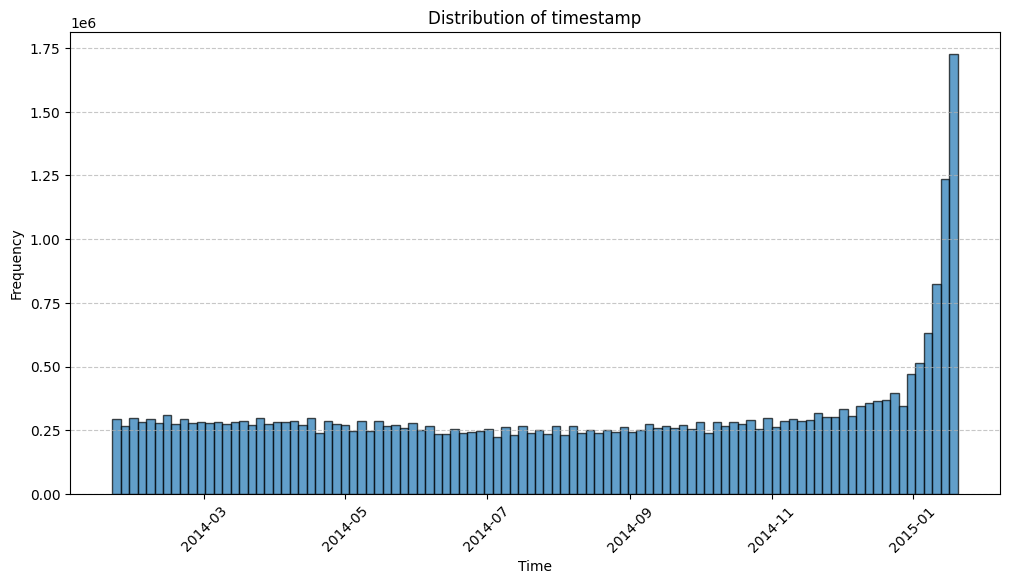

In [17]:
def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 's', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [19]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 2, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 3


In [20]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='s'))
print(pd.to_datetime(interactions.timestamp.max(), unit='s'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.3f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.3f}")

(25639260, 4)
2014-01-20 09:24:20
2015-01-20 09:24:18
Interaction Density: 0.064%
Mean Sequence Length: 577.708


In [21]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 44381
Number of unique items: 909487


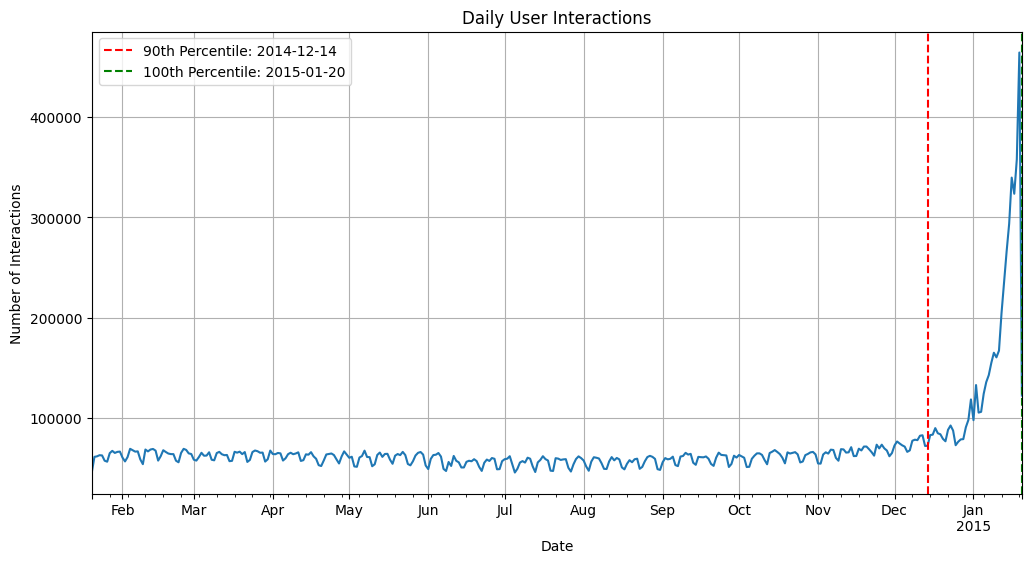

In [22]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='s')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'100th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    global_splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=False,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )
    val_splitter = ColdUserRandomSplitter(
        test_size=0.1,
        drop_cold_items=True,
        query_column="user_id",
        seed=42,
    )
    loo_splitter = LastNSplitter(
        N=1,
        drop_cold_users=True,
        drop_cold_items=False,
        divide_column="user_id",
        query_column="user_id",
        strategy="interactions",
    )

    train, raw_test = global_splitter.split(interactions)
    train_events, val = val_splitter.split(train)
    test_users = set(raw_test['user_id']) - set(val['user_id'])
    test_events, test_gt = loo_splitter.split(
        interactions[
            (interactions['user_id'].isin(test_users))
            & interactions['item_id'].isin(train_events['item_id'].unique())
        ]
    )
    validation_events, validation_gt = loo_splitter.split(val)
    test_gt = test_gt[test_gt['item_id'].isin(train_events['item_id'])]
    test_gt_correct = test_gt[test_gt['user_id'].isin(test_events['user_id'])]
    test_gt = test_gt[test_gt['user_id'].isin(train_events['user_id'])]
    print(
            f"Distribution of seq_len in validation:\n{validation_events.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    print(
        f"Distribution of seq_len in validation gt:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_events.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test gt correct:\n{test_gt_correct.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test gt:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count     4375.000000
mean       479.754514
std       1031.975606
min          1.000000
25%        128.000000
50%        236.000000
75%        531.000000
max      21823.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation gt:
count    4375.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    23247.000000
mean       809.847077
std       1774.189611
min          2.000000
25%        198.000000
50%        470.000000
75%        876.000000
max      88861.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test gt correct:
count    23247.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: item_id, dtype: float64.
Distribution of seq_len in test gt:
count    22674.0
mean         1.0
std          0.0
min          1.